# Zadanie 3

Należy wykreślić skuteczność klasyfikatora $k_{nn}$ w funkcji liczby najbliższych sąsiadów od $k_{nn}=1$ do $k_{nn}=21$. Wykonać to samo dla wartości TP i TN. Następnie wylosować dodatkowo 10 punktów z klasy 1 oraz 5 punktów z klasy 2, potraktować jako zbiór tetsowy i powtórzyć wykresy. Wykonać uśrednienia po 10 losowaniach.

#### Dane:
$S_1 = \begin{pmatrix} 4 & 2 \\ 2 & 4 \end{pmatrix}$  $m_1 = \begin{pmatrix} -1 \\ -1 \end{pmatrix}$ $n_1 = 30$


$S_2 = \begin{pmatrix} 4 & 2 \\ 2 & 4 \end{pmatrix}$  $m_2 = \begin{pmatrix} 2 \\ 2 \end{pmatrix}$ $n_2 = 20$

Pierwszym krokiem będzie (po zaimportowaniu bibliotek) zapisanie parametrów i wygenerowanie danych.

In [1]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

S1 = np.matrix([[4,2], [2,4]])
m1 = np.array([-1, -1])
n1 = 30

S2 = np.matrix([[4,2], [2,4]])
m2 = np.array([2, 2])
n2 = 20

x1 = np.random.multivariate_normal(m1,S1,n1)
y1 = np.repeat(1, n1)
x2 = np.random.multivariate_normal(m2,S2,n2)
y2 = np.repeat(2, n2)

x_con = np.concatenate((x1,x2))
y_con = np.concatenate((y1,y2))

data = np.c_[y_con, x_con]
np.random.shuffle(data) #Wymieszam dane - ułatwi to dalszą ich analizę

Mając dane przygotuję funkcję wykonującą kroswalidację danych dla metody najbliższych sąsiadów oraz zadanej wartości $k$. Funkcja zwraca wartości z przedziału <0; 1> jako wektor $[TP, TN]$.

$TP$ jest liczone jako: $TP = \frac{Tk1}{K1}$, Tk1 - sklasyfikowane jako 1 i rzeczywiście 1, K1 - rzeczywiście jeden. $TN$ jest wyznaczone analogicznie, ale dla klasy 2.

Metoda realizacji kroswalidacji:

1) Podziel zbiór danych na K grup, w których każdy element jest unikatowy - nie powtarza się ani w grupie, ani w innych grupach

2) Dla każdego podzbioru:
    i) Utwórz model na podstawie wszystkich elementów spoza podzbioru (ze zbioru łącznego pozostałych zbiorów)
    ii) Wyznacz TN i TP dla tego modelu dla wybranego podzbioru
    iii) Zapisz te wartości do odpowiednich wektorów przechowujących te informacje dla każdego podzbioru

3) Z wektorów przechowujących wyniki dla każdego podzbioru wyciągnij średnią artmetyczną. Wektory te wyglądają tak: [val_k1, val_k2,...,val_kK]

4) Zwróć wektor w postaci [avg_TP, avg_TN]

In [46]:

# X - zbiór danych
# Y - klasy odpowiadające poszczególnym wektorom
# nn - liczba najbliższych sąsiadów
# K - liczba grup na które będą podzielone dane
def cross_knn(X, Y, nn, K):
    clf = KNeighborsClassifier(n_neighbors=nn)
    periods = np.linspace(0, len(Y), num=K+1, dtype=int)
    periods = list(zip(periods[:-1], periods[1:]))
    tp_acc_vec = np.array([])
    tn_acc_vec = np.array([])
    
    #Podziel na tyle grupy uczące i weryfikujące - wykonaj tyle razy ile jest grup
    for k in range(len(periods)):
        #Wygeneruj listę indeksów do PU
        indexes=np.array([])
        for p in range(len(periods)):
            if p != k:
                indexes = np.concatenate((indexes, np.arange(periods[p][0], periods[p][1])), axis=None)
        
        # Wybierz elementy o indeksach nienależących do grupy weryfikującej
        X_PU = X[[int(i) for i in list(indexes)]]
        Y_PU = Y[[int(i) for i in list(indexes)]]
        
        # Wybierz elementy o indeksach należących do grupy weryfikującej
        X_PW = X[[int(i) for i in list(np.arange(periods[k][0], periods[k][1]))]] 
        Y_PW = Y[[int(i) for i in list(np.arange(periods[k][0], periods[k][1]))]]
        
        # Stwórz model a następnie dokonaj predykcji klas z próby weryfikującej 
        clf.fit(X_PU, Y_PU)
        Y_pred = clf.predict(X_PW)
        tp = ((Y_PW==Y_pred) & (Y_PW==1))
        tn = ((Y_PW==Y_pred) & (Y_PW==2))
        
        tp_acc = len(Y_PW[tp])/len(Y_PW[Y_PW==1])
        tn_acc = len(Y_PW[tn])/len(Y_PW[Y_PW==2])
        
        tp_acc_vec = np.append(tp_acc_vec, tp_acc)
        tn_acc_vec = np.append(tn_acc_vec, tn_acc)
    
    #Mając wyniki walidacji dla różnych podgrup te wyniki należy uśrednić
    avg_tp_acc = np.sum(tp_acc_vec)/len(tp_acc_vec)
    avg_tn_acc = np.sum(tn_acc_vec)/len(tn_acc_vec)
    
    return np.array([avg_tp_acc, avg_tn_acc])

Mając gotową funkcję zwracającą trafność TP i TN przygotuję ich zależność w funkcji knn.

In [51]:
knn_arr = np.arange(1, 22)
result = np.array([])
for knn in knn_arr:
    result=np.append(result, cross_knn(X=data[:,1:3], Y=data[:,0],nn=knn, K=4))

result = np.reshape(result, (len(knn_arr), 2) )
tp_result = result[:,0]
tn_result = result[:,1]

Zmienne tp_result i tn_result będą odpowiadały wartościom na osi Y na wykresie natomiast wartościom na osiach X będzie odpowiadała zmienna knn_arr. 

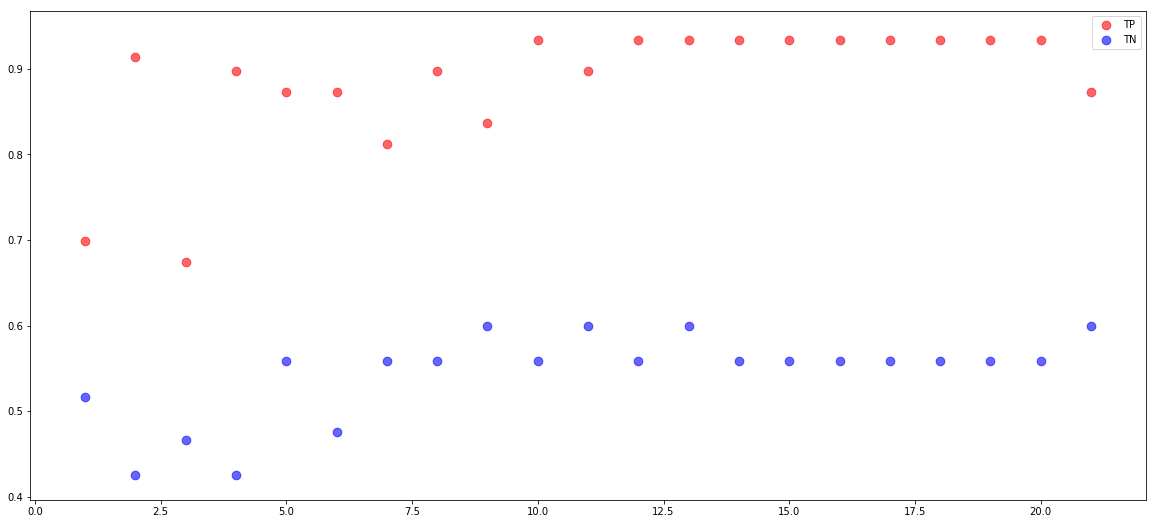

In [52]:
# Tworzę wykres:
figure = plt.figure(figsize=(20,9))
plt.scatter(knn_arr, tp_result,  marker=".", color='red', alpha=0.6, s=300, label='TP')
plt.scatter(knn_arr, tn_result,  marker=".", color='blue', alpha=0.6, s=300, label='TN')
leg = plt.legend()

Można szukać wartości dla największego TP i największego TN:

In [5]:
tp_max = np.max(tp_result)
tn_max = np.max(tn_result)
print("Największe TP wynoszące {:.2f}% odpowiada K =".format(tp_max*100), knn_arr[np.where(tp_result == tp_max)])
print("Największe TN wynoszące {:.2f}% odpowiada K =".format(tn_max*100), knn_arr[np.where(tn_result == tn_max)])

Największe TP wynoszące 93.33% odpowiada K = [10 12 13 14 15 16 17 18 19 20]
Największe TN wynoszące 60.00% odpowiada K = [ 9 11 13 21]
